In [1]:
import glob
import unittest  # The test framework
from itertools import combinations

import pandas as pd
from rdkit import Chem, rdBase

from rgroupinterm.rgroupenumeration import EnumRGroups
from rgroupinterm.rgroup_highlighting import plot_highlighted

rdBase.DisableLog('rdApp.*')

# Case study - regenerating eg5 intermediates
The eg5 set includes a few molecules completely made up of redundant R-groups (i.e. also occuring in other molecules of the set). Here we want to show whether we can regenerate those molecules using r-group enumeration and different pruning criteria. First we will load in the molecules and display the different R-groups.

The eg5 set has 28 unique molecules


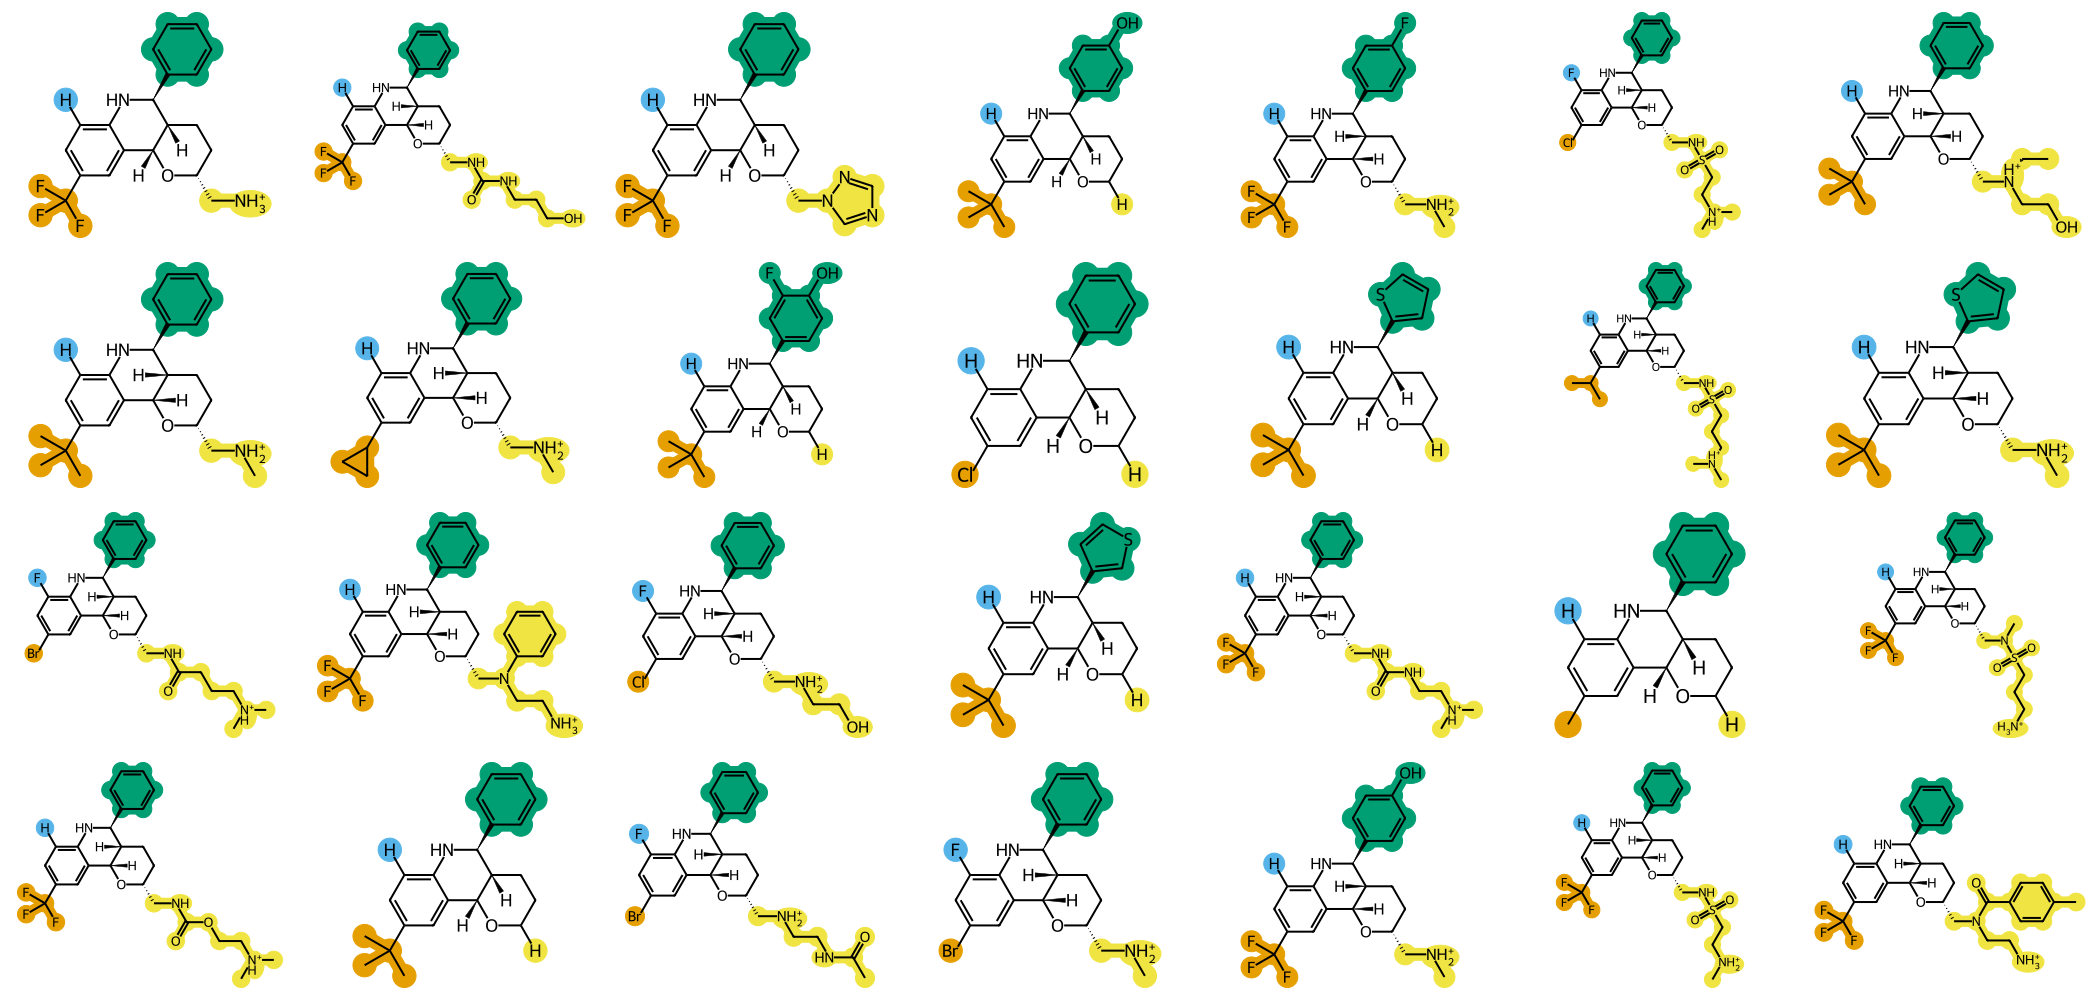

In [2]:
dir = 'eg5'
path = "/zfsdata/data/linde/fep_intermediate_generation/ligands/"
addendum = '*.sdf'
mols = []
for file in glob.glob(path + dir + '/' + addendum):
    mol = Chem.rdmolfiles.SDMolSupplier(file)[0]
    mols.append(mol)
print(f'The eg5 set has {len(mols)} unique molecules')
core = Chem.MolFromSmiles('[C@@H]12CCCO[C@@H]1c3c(NC2)cccc3')
image = plot_highlighted(mols[0], mols[1], mols[2:], core)
display(image)

In [13]:
Chem.MolToSmiles(mols[5])

'C[NH+](C)CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)c1cc(Cl)cc(F)c1N[C@H]2c1ccccc1'

## R-group enumeration
The figure above shows that there's 5 molecules for which all r-groups also occur in other molecules. Here we will remove those molecules from the set, creating a new set of seeding molecules. We will iterate over all the pairs in this set and create intermediates in a pairwise manner. For our 23 seeding molecules this means iterating over 252 pairs, which results in 1364 intermediates of which 544 are unique.

In [3]:
indexes = [7, 13, 22, 24, 25]
seeding_mols = [ele for i, ele in enumerate(mols) if i not in indexes]

df_comb = pd.DataFrame()
for i, (liga, ligb) in enumerate(combinations(seeding_mols, 2)):
    generator = EnumRGroups()
    liga = Chem.Mol(liga)
    ligb = Chem.Mol(ligb)
    df_interm, core = generator.generate_intermediates([liga, ligb])
    df_interm['Intermediate'] = df_interm['Intermediate'].apply(lambda x: Chem.MolToSmiles(x))
    df_interm['Pair'] = i
    df_interm['Parent_1'] = Chem.MolToSmiles(liga)
    df_interm['Parent_2'] = Chem.MolToSmiles(ligb)
    df_comb = pd.concat([df_comb, df_interm], ignore_index=True)

# df_comb.to_csv('data/eg_5_intermediates.csv', index=False)

print(f'Number of pairs: {i}')
print(f'Number of intermediates: {len(df_comb)}')
print(f'Number of unique intermediates: {len(df_comb.Intermediate.unique())}')

Number of pairs: 252
Number of intermediates: 1364
Number of unique intermediates: 544


## Target molecules are regenerated
Next we will check whether the molecules we removed from the dataset (our target molecules) are created by the r-group enumeration, by comparing the intermediate SMILES to the target SMILES.

In [4]:
target_mols = [ele for i, ele in enumerate(mols) if i in indexes]
target_smiles = [Chem.MolToSmiles(x) for x in target_mols]
df_target = df_comb[df_comb['Intermediate'].isin(target_smiles)].reset_index(drop=True)
display(df_target)
print(
    f'Number of regererated target molecules: {len(df_target.Intermediate.unique())}'
)

,Intermediate,Pair,Parent_1,Parent_2
0,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,2,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3...
1,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,7,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C(F)=C3)[C@@...
2,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,9,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=CS3)[C@@H]3CCCO[...
3,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,14,[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...
4,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,23,O=C(NCCCO)NC[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)...,CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3...
...,...,...,...,...
83,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,227,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,CN(C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(C(F)(F)F)=CC...
84,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,228,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,C[NH+](C)CCOC(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1=...
85,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,229,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,CC(=O)NCC[NH2+]C[C@H]1CC[C@@H]2[C@H](O1)C1=CC(...
86,CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc...,230,CC(C)(C)C1=CC=C2N[C@@H](C3=CSC=C3)[C@@H]3CCCO[...,C[NH2+]CCS(=O)(=O)NC[C@H]1CC[C@@H]2[C@H](O1)C1...


Number of regererated target molecules: 5


## Pruning of generated intermediates
As R-group enumeration yields a lot of new intermediates with different degrees of usefulness for RFBE we have also created pruning mechanisms.

In [7]:
from rgroupinterm.pruners import BasePruner, TanimotoScorer, HarmonicMeanTransformer
import pandas as pd
from rdkit import Chem

df = pd.read_csv('data/eg_5_intermediates.csv')
df_mols = pd.DataFrame()
for column in ['Intermediate', 'Parent_1', 'Parent_2']:
    df_mols[column] = df[column].apply(lambda x: Chem.MolFromSmiles(x))
df_mols['Pair'] = df['Pair']

In [24]:
pruner = BasePruner(
    [TanimotoScorer(transformer=HarmonicMeanTransformer(exponent=4))], topn=5)
pruned_df = pruner(df_mols)

In [25]:
for column in ['Intermediate', 'Parent_1', 'Parent_2']:
    pruned_df[column] = pruned_df[column].apply(lambda x: Chem.MolToSmiles(x))
df_target = pruned_df[pruned_df['Intermediate'].isin(
        target_smiles)].reset_index(drop=True)

In [26]:
print(
    f'Number of regererated target molecules: {len(df_target.Intermediate.unique())}'
)

Number of regererated target molecules: 5


Plot tanimoto distance of intermediates to pair

(0.0, 1.0)

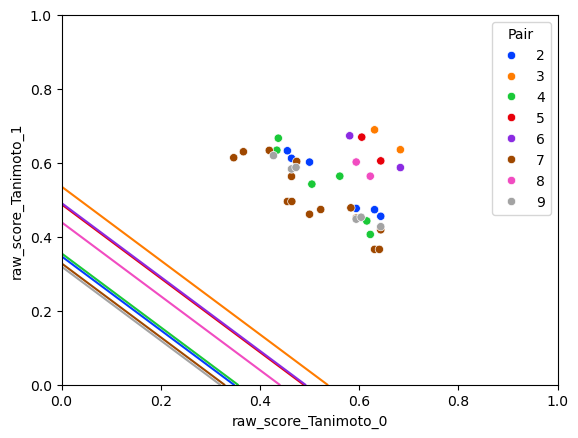

In [35]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

palette = sns.color_palette("bright")

path = 'data/eg5_scored.csv'
df = pd.read_csv(path)
df = df.loc[df['Pair']<10]

sns.scatterplot(data=df, x="raw_score_Tanimoto_0", y="raw_score_Tanimoto_1", hue="Pair", legend="full", palette='bright')

df_p = pd.read_csv('data/eg5_score_parents.csv')
for i, pair in enumerate(df.Pair.unique()):
    parent_score = df_p.loc[df_p['Pair'] ==
                            pair]['raw_score_Tanimoto_p'].values[0]
    plt.plot([0, parent_score], [parent_score, 0], color=palette[i])

plt.xlim([0, 1])
plt.ylim([0, 1])

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

palette = sns.color_palette("bright")

path = 'data/eg5_scored.csv'
df = pd.read_csv(path)
df = df.loc[df['Pair']<10]

# for each pair normalize the score

sns.scatterplot(data=df, x="raw_score_Tanimoto_0", y="raw_score_Tanimoto_1", hue="Pair", legend="full", palette='bright')

df_p = pd.read_csv('data/eg5_score_parents.csv')
for i, pair in enumerate(df.Pair.unique()):
    parent_score = df_p.loc[df_p['Pair'] ==
                            pair]['raw_score_Tanimoto_p'].values[0]
    plt.plot([0, parent_score], [parent_score, 0], color=palette[i])

plt.xlim([0, 1])
plt.ylim([0, 1])

array([[<Axes: title={'center': 'raw_score_Tanimoto_p'}>]], dtype=object)

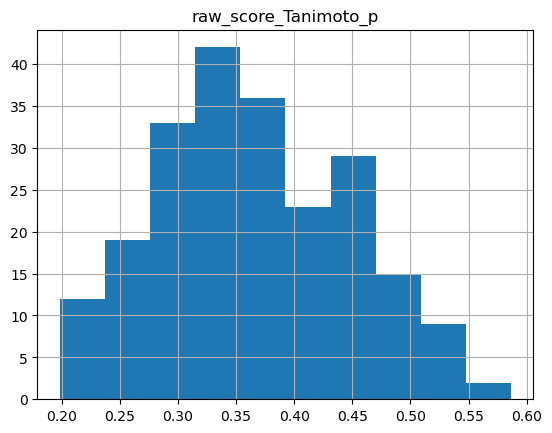

In [4]:
df = pd.read_csv('data/eg5_score_parents.csv')
df.hist('raw_score_Tanimoto_p')